# Arbitrary current or voltage profiles

This is a further example to output arbitrary user defined current or voltage waveforms with the potentiostat and measure voltage and current.

The profiles are realized via the sequential execution of the polarisation or ramp primitives, therefore the restrictions and conditions of the two primitives also apply here.

The measurements do not necessarily have to make sense from an electrochemical point of view.  
They are only there to explain the configuration of the primitive and different applications.

In [4]:
from zahner_potentiostat.scpi_control.searcher import SCPIDeviceSearcher
from zahner_potentiostat.scpi_control.serial_interface import SerialCommandInterface, SerialDataInterface
from zahner_potentiostat.scpi_control.control import *
from zahner_potentiostat.scpi_control.datahandler import DataManager
from zahner_potentiostat.scpi_control.datareceiver import TrackTypes
from zahner_potentiostat.display.dcplot import DCPlot
from zahner_potentiostat.display.onlinedisplay import OnlineDisplay
from zahner_potentiostat.drivecycle.cycle_importer import getNormalisedCurrentTableForNYCCCOL

from jupyter_utils import executionInNotebook, notebookCodeToPython

if __name__ == '__main__':
    deviceSearcher = SCPIDeviceSearcher()
    deviceSearcher.searchZahnerDevices()
    commandSerial, dataSerial = deviceSearcher.selectDevice()
    ZahnerPP2x2 = SCPIDevice(SerialCommandInterface(commandSerial), SerialDataInterface(dataSerial))
    ZahnerPP2x2.clearState()

COM10:
ZAHNER-ELEKTRIK,PP212,33000,1.0.0 binary

COM9:
ZAHNER-ELEKTRIK,PP212,33000,1.0.0



# Setting general parameters
First of all, general parameters are set, which will be used in all primitives that will be executed.

During measurement, the second shunt is always used without autoranging.  
For this purpose, the second shunt is inserted and then the minimum and maximum shunt is also set to index two. This is necessary because the primitives automatically change the shunt after the current in the case of galvanostatic output.

In [ ]:
    ZahnerPP2x2.setRaiseOnErrorEnabled(True)
    ZahnerPP2x2.calibrateOffsets()
    ZahnerPP2x2.setSamplingFrequency(20)
    
    ZahnerPP2x2.setAutorangingEnabled(False)
    ZahnerPP2x2.setInterpolationEnabled(False)
    
    ZahnerPP2x2.setShuntIndex(2)
    ZahnerPP2x2.setMinimumShuntIndex(2)
    ZahnerPP2x2.setMaximumShuntIndex(2)
    
    ZahnerPP2x2.setVoltageRangeIndex(0)

# Starting the live data display

With the following command, a plotting window can be opened, in which the measured voltage and current points from the measuring device are displayed live.

The check whether the execution takes place in the Jupyter notebook with the function executionInNotebook() is only necessary because Jupyter cannot display the measured data live.  
Therefore, if the execution takes place in Jupyter, the online display is not executed.

In [3]:
    onlineDisplay = None
    if executionInNotebook() == False:
        onlineDisplay = OnlineDisplay(ZahnerPP2x2.getDataReceiver())

# Arbitrary galvanostatic profile

As an example of data for the profiles, the speed of [dynamometer drive schedules](https://www.epa.gov/vehicle-and-fuel-emissions-testing/dynamometer-drive-schedules) is normalized and output as current with an individual factor.

These data are only conditionally realistic under the assumption that the current depends linearly on the speed.

## Setup measurement

Set limits to protect the connected 18650 lithium-manganese battery (Samsung ICR18650-26JM) with 2.6 Ah.

In [ ]:
    ZahnerPP2x2.setMinimumCurrentGlobal(-8)
    ZahnerPP2x2.setMaximumCurrentGlobal(4)
    ZahnerPP2x2.setGlobalCurrentCheckEnabled(True)
    
    ZahnerPP2x2.setMinimumVoltageGlobal(3.0)
    ZahnerPP2x2.setMaximumVoltageGlobal(4.25)
    ZahnerPP2x2.setGlobalVoltageCheckEnabled(True)

## Loading the example drive cycle

For this example, a [new york drive cycle](https://www.epa.gov/sites/production/files/2015-10/nycccol.txt) is used. This template is included in the library.

The profile must be passed with the following data structure:  
*[{"time": 0, "value": 0.1}, {"time": 1, "value": 0.4}, {"time": 2, "value": 0.3}]*
            
The structure is an array with a dictionary for each step. The dictionary has two keys:
* time: The time point of the value.
* value: The value, current or voltage, depending on the parameter coupling.

For the example, only a part of the profile is measured.

In [5]:
    driveCycle = getNormalisedCurrentTableForNYCCCOL()
    driveCycle = driveCycle[0:245]

## Parameterize and execute the cycle

The scalingFactor is multiplied by the value keys from the profileDict, for example to adjust the current for different cell sizes.  
The scaling factor of -1.5 A is used so that the positive speed values become a negative current which discharges the battery.  
As an output primitive, the polarization is used, but ramps are also possible.

The profile is then executed with [measureProfile()](http://zahner.de/documentation/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.measureProfile). The complete documentation can be found in the [API documentation](http://zahner.de/documentation/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.measureProfile).

In [6]:
    ZahnerPP2x2.measureProfile(profileDict = driveCycle,
                               coupling = COUPLING.GALVANOSTATIC,
                               scalingFactor = -1.5,
                               outputPrimitive = "pol")

## Plot the data

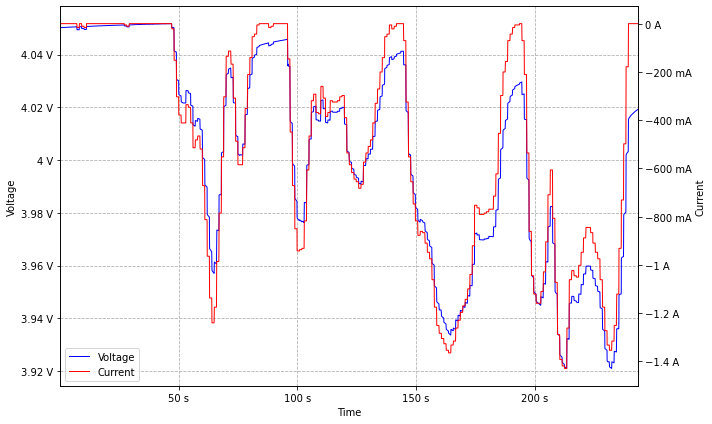

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [7]:
    dataReceiver = ZahnerPP2x2.getDataReceiver()
    dataManager = DataManager(dataReceiver)
    dataManager.plotTIUData("profile.pdf",10,5)

# Close the connection

Closing the online display when it has been opened and close the connection to the device.

In [8]:
    if onlineDisplay != None:
        onlineDisplay.close()
    
    ZahnerPP2x2.close()
    print("finish")

finish


# Deployment of the source code

**The following instruction is not needed by the user.**

It automatically extracts the pure python code from the jupyter notebook to provide it for the user.  
Thus the user does not need jupyter itself and does not have to copy the code manually.

The code is stored in a notebook-like file with the extension .py.

In [5]:
    if executionInNotebook() == True:
        notebookCodeToPython("ArbitraryProfile.ipynb")